In [363]:
import numpy as np
import numpy.ma as ma
#import cv2
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io.fits import getdata
import h5py
import sunpy.map as smap
from sunpy.net import Fido, attrs as a
from astropy.modeling import models, fitting
import warnings
warnings.filterwarnings("ignore")
import hazel
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
import skimage
from skimage import measure
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import sys
import pandas as pd
from natsort import natsorted
import math
import re 


# Index

1. Functions

2. Set directories and magnetogram date 

3. Organize maps to analyse

4. Contours of the conditions

5. Barycenters

6. Distance Between Barycenters


# 1. Functions

In [364]:
def Bz_maps (output,sg):
    #note: dir_outputs within the function, so this function does not work for non hazel inversion outputs, as the path file is not the same
    f = h5py.File(dir_outputs+output, 'r')
    t = 22
    ph1 = f['ph1']

    if (np.sqrt(ph1['Bx'][:,:,t].shape[0]) - int(np.sqrt(ph1['Bx'][:,:,t].shape[0])) != 0):
        nx = int(np.sqrt(ph1['Bx'][:,:,t].shape[0]))+1
        ny = int(np.sqrt(ph1['Bx'][:,:,t].shape[0]))
        #print("Original map shape: nx != ny")
    else: 
        nx = int(np.sqrt(ph1['Bx'][:,:,t].shape[0]))
        ny = int(np.sqrt(ph1['Bx'][:,:,t].shape[0]))
        #print("Original map shape: nx == ny")
    Bx = np.squeeze(ph1['Bx'][:,:,t]).reshape((nx,ny))
    By = np.squeeze(ph1['By'][:,:,t]).reshape((nx,ny))
    Bz = np.squeeze(ph1['Bz'][:,:,t]).reshape((nx,ny))
    f.close()
    Bz = gaussian_filter(Bz, sigma=sg)
        
    return (Bz)

def multi_plot(plots,n_rows,n_columns,width,height):
    fig = plt.figure(figsize=(width,height))
    fig.add_subplot(n_rows,n_columns,1).imshow(plots[:,:,0],cmap='seismic',
                                                 vmax=np.max(VFISV_map),vmin=np.min(VFISV_map))
    fig.add_subplot(n_rows,n_columns,1).set_title('VFISV',fontsize = 25)
    fig.add_subplot(n_rows,n_columns,2).imshow(plots[:,:,1],cmap='seismic',
                                                 vmax=np.max(VFISV_map),vmin=np.min(VFISV_map))
    fig.add_subplot(n_rows,n_columns,2).set_title('Hazel 2',fontsize = 25)
    for i in range(len(plots[0,0])-2):
        fig.add_subplot(n_rows,n_columns,i+3).imshow(plots[:,:,i+2],cmap='seismic',vmax=np.max(VFISV_map),vmin=np.min(VFISV_map))
        fig.add_subplot(n_rows,n_columns,i+3).set_title('r cm = '+atm_glob[i][81:84],fontsize = 25)
        
        
def plot_contour(map_to_contour,color_line,line_width):

    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(221)
    ax1.imshow(maps[:,:,map_to_contour], cmap=plt.cm.seismic,vmax=np.max(VFISV_map),vmin=np.min(VFISV_map))
    plt.title('40 % condition '+titles[map_to_contour],fontsize=25)
    contours = measure.find_contours(maps[:,:,map_to_contour], conditions[0,map_to_contour])
    contours1 = measure.find_contours(maps[:,:,map_to_contour], conditions[1,map_to_contour])
    for contour in contours:
        ax1.step(contour[:, 1], contour[:, 0], c = color_line ,linewidth=line_width)
    for contour1 in contours1:
        ax1.step(contour1[:, 1], contour1[:, 0], c = color_line ,linewidth=line_width)    
########### 99% ###########################################################################
    ax2 = fig.add_subplot(222)
    ax2.imshow(maps[:,:,map_to_contour], cmap=plt.cm.seismic,vmax=np.max(VFISV_map),vmin=np.min(VFISV_map))
    plt.title('99 % condition '+titles[map_to_contour],fontsize=25)
    contours2 = measure.find_contours(maps[:,:,map_to_contour], conditions[2,map_to_contour])
    contours3 = measure.find_contours(maps[:,:,map_to_contour], conditions[3,map_to_contour])
    
    if (len(np.asarray(contours2)[0]) <= 5):
        for i in range(len(np.asarray(contours2)[0])):
            ax2.scatter(np.asarray(contours2)[:,i,1],np.asarray(contours2)[:,i,0],color=color_line,s=5)
    else:
        for contour2 in contours2:
            ax2.step(contour2[:, 1], contour2[:, 0], c = color_line ,linewidth=line_width)
        
    if (len(np.asarray(contours3)[0]) <= 5):
        for i in range(len(np.asarray(contours3)[0])):
            ax2.scatter(np.asarray(contours3)[:,i,1],np.asarray(contours3)[:,i,0],color=color_line,s=5)
    else:
        
        for contour3 in contours3:
            ax2.step(contour3[:, 1], contour3[:, 0], c = color_line ,linewidth=line_width)
        
def plot_contour_and_barycenters(map_to_contour,color_line,line_width,contours_plot,alpha):

    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(221)
    ax1.imshow(maps[:,:,map_to_contour], cmap=plt.cm.seismic,vmax=np.max(VFISV_map),vmin=np.min(VFISV_map))
    plt.title('40 % condition '+titles[map_to_contour],fontsize=25)
    plt.plot(barycenters[0,map_to_contour,1],barycenters[0,0,0], 'k*', markersize = 20,alpha=alpha) 
    plt.plot(barycenters[1,map_to_contour,1],barycenters[1,0,0],'k*', markersize = 20,alpha=alpha) 
    
    ax2 = fig.add_subplot(222)
    ax2.imshow(maps[:,:,map_to_contour], cmap=plt.cm.seismic,vmax=np.max(VFISV_map),vmin=np.min(VFISV_map))
    plt.title('99 % condition '+titles[map_to_contour],fontsize=25)
    plt.plot(barycenters[2,map_to_contour,1],barycenters[2,0,0], 'k*', markersize = 20,alpha=alpha) 
    plt.plot(barycenters[3,map_to_contour,1],barycenters[3,0,0],'k*', markersize = 20,alpha=alpha) 
    

    if (contours_plot == True):
        contours = measure.find_contours(maps[:,:,map_to_contour], conditions[0,map_to_contour])
        contours1 = measure.find_contours(maps[:,:,map_to_contour], conditions[1,map_to_contour])
        contours2 = measure.find_contours(maps[:,:,map_to_contour], conditions[2,map_to_contour])
        contours3 = measure.find_contours(maps[:,:,map_to_contour], conditions[3,map_to_contour])
        for contour in contours:
            ax1.step(contour[:, 1], contour[:, 0], c = color_line ,linewidth=line_width)
        for contour1 in contours1:
            ax1.step(contour1[:, 1], contour1[:, 0], c = color_line ,linewidth=line_width)
            
            
        if (len(np.asarray(contours2)[0]) <= 5):
            for i in range(len(np.asarray(contours2)[0])):
                ax2.scatter(np.asarray(contours2)[:,i,1],np.asarray(contours2)[:,i,0],color=color_line,s=5)
        else: 
            for contour2 in contours2:
                ax2.step(contour2[:, 1], contour2[:, 0], c = color_line ,linewidth=line_width)        
                
        if (len(np.asarray(contours3)[0]) <= 5):
            for i in range(len(np.asarray(contours3)[0])):
                ax2.scatter(np.asarray(contours3)[:,i,1],np.asarray(contours3)[:,i,0],color=color_line,s=5)
        else:    
            for contour3 in contours3:
                ax2.step(contour3[:, 1], contour3[:, 0], c = color_line ,linewidth=line_width)
            
    


# 2. Set directories and magnetogram date

In [365]:
sunspot_date = '20121117_010000'
sunspot_date1 = '2012-11-17T01:04:00'

#set the hazel inversion parameters of the reconstructed field
Branges = '_BxyxR3500'
Bnodes = '_Bxyz221'
StokesW = '_IQUV1553.5'

dir_outputs = '/home/miguel/Solar-physics-project/Thesis/inversions/outputs/'
dir_magnetogram = '/home/miguel/Solar-physics-project/Thesis/magnetograms/submpas_magnetogram_'+sunspot_date1+'/'
dir_full_magnetogram = '/home/miguel/Solar-physics-project/Thesis/magnetograms/magnetogram_'+sunspot_date1+'/'



In [366]:
#VFISV and Hazel magnetogram

hazel_map = Bz_maps('output_3d_'+sunspot_date+Branges+Bnodes+StokesW+'.h5',0.8)
VFISV_map = fits.getdata(dir_magnetogram+'submap.hmi.m_720s.'+sunspot_date+'_TAI.1.magnetogram.fits')
nrows = len(VFISV_map)
ncolumns = len(VFISV_map[0])
print('VFISV and Hazel maps: \n number of rows and columns',nrows,ncolumns)
#Set the Hazel inversion with atmosphere
#get the data to set the maximun and minimum values of all the magnetograms (the reference map is from VFISV code)
print('VFISV magnetogram maxs and mins', round(np.max(VFISV_map),2),'[G]', round(np.min(VFISV_map),2),'[G]')

print('Hazel normal magnetogram maxs and mins', round(np.max(hazel_map),2),'[G]', round(np.min(hazel_map),2),'[G]')

VFISV and Hazel maps: 
 number of rows and columns 200 199
VFISV magnetogram maxs and mins 1288.91 [G] -1722.02 [G]
Hazel normal magnetogram maxs and mins 1316.02 [G] -2017.79 [G]


In [759]:
atm_glob = natsorted(glob.glob(dir_outputs+'output_3d_atm_r0_cm_*.h5'),key=str,reverse=True)
print('Atm maps: ')
g_atm = 61
for i in range(len(atm_glob)): 
    print(atm_glob[i][g_atm:])
    

Atm maps: 
output_3d_atm_r0_cm_10.0_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5
output_3d_atm_r0_cm_4.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5
output_3d_atm_r0_cm_3.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5
output_3d_atm_r0_cm_2.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5
output_3d_atm_r0_cm_1.5_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5
output_3d_atm_r0_cm_1.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5


# 3. Organize maps to analyse

In [761]:
#atm map output_3d_atm_r0_cm_1.00_20121117_010000_BxyxR3500_Bxyz221_IQUV1553.5.h5
output_to_get_shape = 'output_3d_atm_r0_cm_1.00_'+sunspot_date+Branges+Bnodes+StokesW+'.h5'

#input image size
nrows_atm = Bz_maps(output_to_get_shape,0).shape[0]
ncolumns_atm = Bz_maps(output_to_get_shape,0).shape[1]
print('Atm maps shape nrows: ',nrows_atm,'ncolumns: ',ncolumns_atm)

atm_maps = np.ndarray(shape=(nrows_atm,ncolumns_atm,len(atm_glob)), dtype=float)
print(atm_maps.shape)


#transform maps into numpy arrays
for i in range(len(atm_glob)):
    atm_maps[:,:,i] = -np.asarray(Bz_maps(atm_glob[i][61:],0.0)) #######¡¡¡¡¡¡¡¡ minus sign added to invert polarity !!!!!!!!!!!!!!!
    
    
VFISV_map_crop = VFISV_map[int(((nrows - nrows_atm)/2)):-int(math.ceil(((nrows - nrows_atm)/2))),
                           int(((ncolumns - ncolumns_atm)/2) ):-int(math.ceil(((ncolumns - ncolumns_atm)/2) ))]
hazel_map_crop = hazel_map[int(((nrows - nrows_atm)/2)):-int(math.ceil(((nrows - nrows_atm)/2))),
                           int(((ncolumns - ncolumns_atm)/2) ):-int(math.ceil(((ncolumns - ncolumns_atm)/2) ))]

print('VFISV map new shape: ',VFISV_map_crop.shape)
print('hazel map new shape: ',hazel_map_crop.shape)
print('Atm maps shape: ',atm_maps.shape)
    
    
    
maps = np.ndarray(shape=(len(atm_maps),len(atm_maps),2+len(atm_maps[0,0])),dtype=float)
maps[:,:,0] = VFISV_map_crop
maps[:,:,1] = hazel_map_crop
for i in range(len(atm_maps[0,0])):
    maps[:,:,i+2] = atm_maps[:,:,i]
    
print('All maps array shape: ',maps.shape)

Atm maps shape nrows:  177 ncolumns:  177
(177, 177, 6)
VFISV map new shape:  (177, 177)
hazel map new shape:  (177, 177)
Atm maps shape:  (177, 177, 6)
All maps array shape:  (177, 177, 8)


In [762]:
#test resized to extract shape
resize_factor = 0.5
test = resize(maps[:,:,0], (maps[:,:,0].shape[0] // resize_factor, maps[:,:,0].shape[1] // resize_factor),
                       anti_aliasing=True)

image_resized = np.ndarray(shape=(test.shape[0],test.shape[1],maps.shape[2]), dtype=float)
for rz in range(maps.shape[2]):
    image_resized[:,:,rz] = resize(maps[:,:,rz], (maps[:,:,rz].shape[0] // resize_factor, maps[:,:,rz].shape[1] // resize_factor),anti_aliasing=True)

print('Image original shape: ',maps.shape,'\n Image resized shape: ',image_resized.shape)
#multi_plot(VFISV_map,hazel_map,image_resized,2,4,len(atm_glob),20,10)
maps = image_resized

Image original shape:  (177, 177, 8) 
 Image resized shape:  (354, 354, 8)


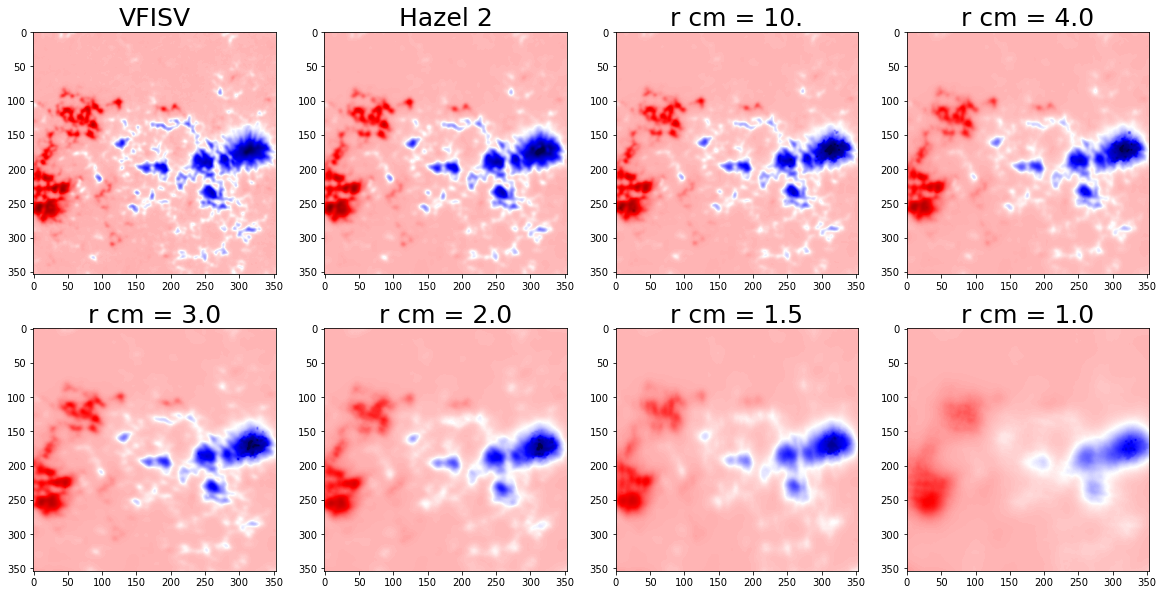

In [763]:
multi_plot(maps,2,4,20,10)
#atm_amps, # rows, # columns, # plots

# 4. Contours of the conditions

In [764]:
conditions = np.ndarray(shape=(4,2+atm_maps.shape[2]),dtype=float)
for k in range(len(maps[0,0])):
    conditions[0,k] = (np.max(maps[:,:,k])*40)/100
    conditions[1,k] = (np.min(maps[:,:,k])*40)/100
    conditions[2,k] = (np.max(maps[:,:,k])*99)/100
    conditions[3,k] = (np.min(maps[:,:,k])*99)/100        

#Condition array 
#        Columns  
# Rows   VFISV    Hazel    Atmaps 1  2  3  4  5  6
# 40 max  ...      ...      ...   .  .  .  .  .  .
# 40 min
# 99 max
# 99 min


['VFISV', 'Hazel', 'r cm = 10.', 'r cm = 4.0', 'r cm = 3.0', 'r cm = 2.0', 'r cm = 1.5', 'r cm = 1.0']


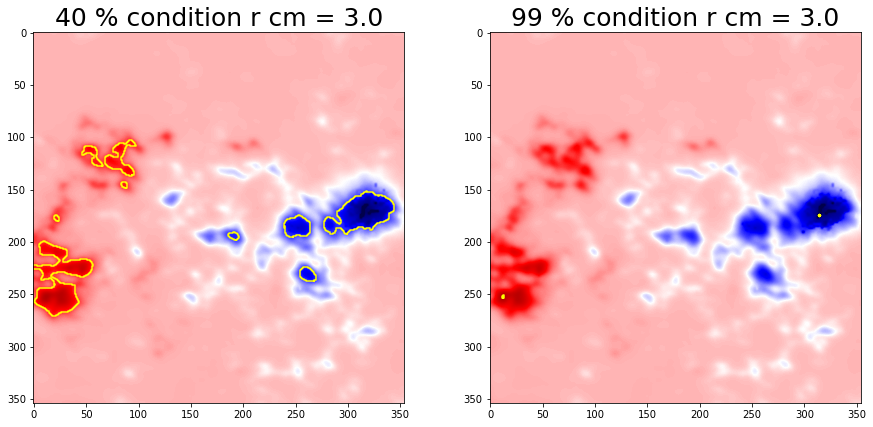

In [765]:
titles_atm = []
titles = ['VFISV','Hazel']

for i in range(len(atm_glob)):
    titles_atm.append('r cm = '+atm_glob[i][81:84])
titles = titles + titles_atm
print(titles)

#for i in range(len(maps[0,0])):
#    plot_contour(i,'white',1)

plot_contour(4,'yellow',1.5)

# 5. Barycenters

In [766]:
barycenters = np.ndarray(shape=(4,maps.shape[2],2),dtype=float)
for k in range(len(maps[0,0])):
    barycenters[0,k] = np.asarray(ndimage.center_of_mass(ma.masked_less(maps[:,:,k],conditions[0,k])))
    barycenters[1,k] = np.asarray(ndimage.center_of_mass(ma.masked_greater(maps[:,:,k],conditions[1,k])))
    barycenters[2,k] = np.asarray(ndimage.center_of_mass(ma.masked_less(maps[:,:,k],conditions[2,k])))
    barycenters[3,k] = np.asarray(ndimage.center_of_mass(ma.masked_greater(maps[:,:,k],conditions[3,k])))

#Barycenter array 
#        Columns  
# Rows   VFISV    Hazel    Atmaps 1  2  3  4  5  6
# 40 max  (b1,b2) (b1,b2)   .  .  .  .  .  .
# 40 min
# 99 max
# 99 min
print('(conditions, maps, barycenter (x,y)): ',barycenters.shape)

(conditions, maps, barycenter (x,y)):  (4, 8, 2)


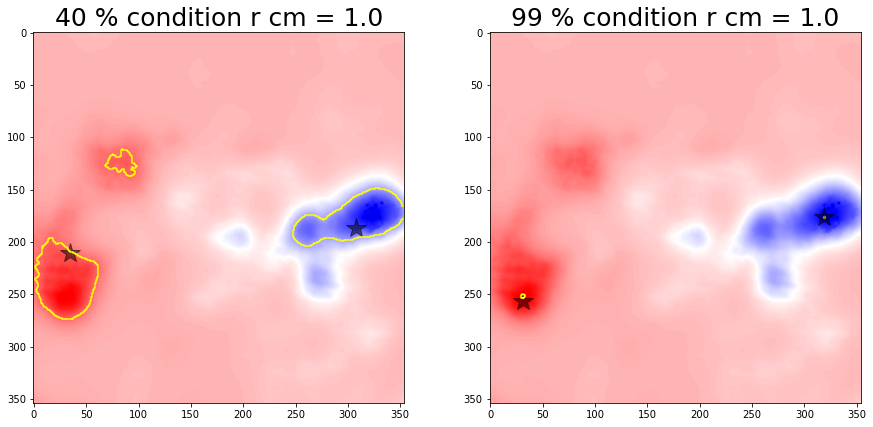

In [767]:

plot_contour_and_barycenters(7,'yellow',1.5,contours_plot=True,alpha=0.5)

# 6. Distance Between Barycenters

In [768]:
distances = np.ndarray(shape=(2,maps.shape[2]),dtype=float)


for j in range(len(maps[0,0])):
    distances[0,j] = np.linalg.norm(barycenters[0,j]-barycenters[1,j])
    distances[1,j] = np.linalg.norm(barycenters[2,j]-barycenters[3,j])

#Distances array 
#        Columns  
# Rows   VFISV    Hazel    Atmaps 1  2  3  4  5  6
# 40     . . .    . . .    . . .
# 99


In [773]:
pattern = r'cm_'

r0cms = []
for i in range(len(atm_glob)):
    result = re.search(pattern,atm_glob[i])
    r0cms.append(atm_glob[i][result.span()[0]+3:result.span()[1]+3])

print(r0cms)

['10.', '4.0', '3.0', '2.0', '1.5', '1.0']


In [774]:
r0cms_num = []

for i in range(len(r0cms)):
    if (re.search(r'\D',r0cms[i][2]) != None):
        r0cms_num.append(float(r0cms[i].replace(r0cms[i][2], '')))
    elif((re.search(r'_',r0cms[i][1]) != None)):
        r0cms_num.append(float(r0cms[i].replace(r0cms[i][1:], '')))
    else:
        r0cms_num.append(float(r0cms[i]))
        
r0cms_num = sorted(r0cms_num,reverse=True)
print(r0cms_num)

[10.0, 4.0, 3.0, 2.0, 1.5, 1.0]


In [775]:
hdul = fits.open(dir_full_magnetogram+'/hmi.m_720s.'+sunspot_date+'_TAI.1.magnetogram.fits')
arcsec_pixel = hdul[1].header['CDELT1']
print('Map pixel size: ',arcsec_pixel,'[arcsec/pixel]')

Map pixel size:  0.504298508 [arcsec/pixel]


In [776]:
errors = np.ndarray(shape=(2,maps.shape[2],2),dtype=float)


for j in range(len(maps[0,0])):
    errors[0,j,0] = abs(distances[0,j] - distances[0,0])
    
    errors[0,j,1] =  (abs(distances[0,0] - distances[0,j])/distances[0,j])*100
    
    errors[1,j,0] = abs(distances[1,j] - distances[1,0])
    
    errors[1,j,1] =  (abs(distances[1,0] - distances[1,j])/distances[1,j])*100
    
#Errors array 
#        Columns  
# Rows   VFISV    Hazel    Atmaps 1  2  3  4  5  6
# 40     (AE,RE)
# 99


In [780]:
hazel_AE_distances_40con = abs(distances[0,1] - distances[0,0])
hazel_RE_distances_40con = abs(-hazel_AE_distances_40con/distances[0,1])*100

print('Hazel inversion barycienter distance 40% condition \nAbsolute Error: ',round(errors[0,1,0],2)
      ,'pixels  ',round(errors[0,1,0]*arcsec_pixel,2), ' [arcsec/pixel]')

print('Relative Error: ',round(errors[0,1,1],2),'%')

Hazel inversion barycienter distance 40% condition 
Absolute Error:  9.2 pixels   4.64  [arcsec/pixel]
Relative Error:  3.61 %


Text(0, 0.5, 'Distance [arcsec]')

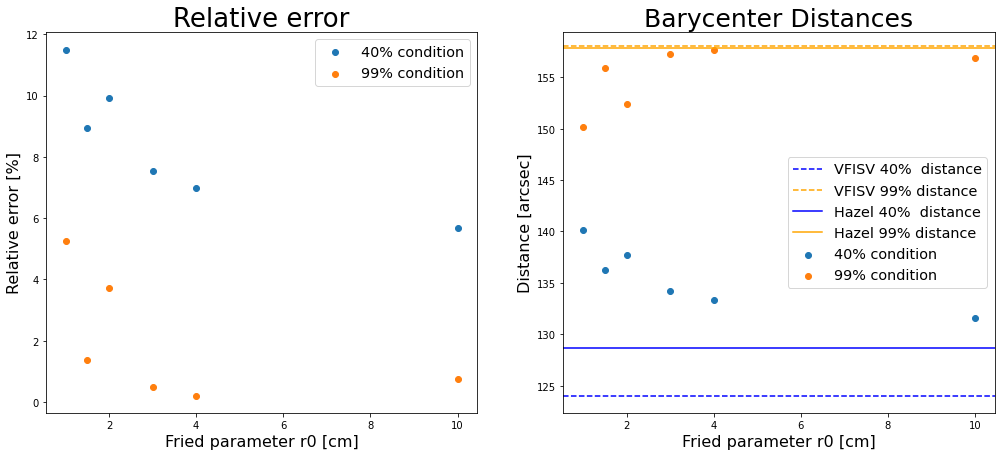

In [833]:
p_40_err = np.poly1d(np.polyfit(r0cms_num, errors[0,2:,1], 2))
p_99_err = np.poly1d(np.polyfit(r0cms_num, errors[1,2:,1], 2))

p_40_dist = np.poly1d(np.polyfit(r0cms_num, distances[0,2:]*arcsec_pixel, 2))
p_99_dist = np.poly1d(np.polyfit(r0cms_num, distances[1,2:]*arcsec_pixel, 2))

x_new = np.linspace(np.min(r0cms_num), int(np.max(r0cms_num)),len(r0cms_num)*10 )

y_40_err = p_40_err(x_new)
y_99_err = p_99_err(x_new)

y_40_dist = p_40_dist(x_new)
y_99_dist = p_99_dist(x_new)

fig = plt.figure(figsize=(17,7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(r0cms_num[:],errors[0,2:,1],label='40% condition')
ax1.scatter(r0cms_num[:],errors[1,2:,1],label='99% condition')
#ax1.plot(x_new, y_40_err,'-',color='blue')
#ax1.plot(x_new, y_99_err,'-',color='orange')
ax1.set_title('Relative error', fontsize = 26)
ax1.set_ylabel('Relative error [%]',fontsize = 16)
ax1.set_xlabel('Fried parameter r0 [cm]',fontsize = 16)
ax1.legend(fontsize='x-large')
ax2.scatter(r0cms_num[:],distances[0,2:]*arcsec_pixel,label='40% condition')
ax2.scatter(r0cms_num[:],distances[1,2:]*arcsec_pixel,label='99% condition')
ax2.axhline(distances[0,0]*arcsec_pixel,color='blue',linestyle='--',label='VFISV 40%  distance')
ax2.axhline(distances[1,0]*arcsec_pixel,color='orange',linestyle='--',label='VFISV 99% distance')
ax2.axhline(distances[0,1]*arcsec_pixel,color='blue',linestyle='-',label='Hazel 40%  distance')
ax2.axhline(distances[1,1]*arcsec_pixel,color='orange',linestyle='-',label='Hazel 99% distance')
#ax2.plot(x_new, y_40_dist,'-',color='blue')
#ax2.plot(x_new, y_99_dist,'-',color='orange')
ax2.legend(fontsize='x-large')
ax2.set_title('Barycenter Distances', fontsize = 25)
ax2.set_xlabel('Fried parameter r0 [cm]',fontsize = 16)
ax2.set_ylabel('Distance [arcsec]',fontsize=16)